In [34]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [6]:
NUM_PROC = 8
DATASET_CONFIG = BaseDatasetConfig(
    name="ljspeech", meta_file_train="metadata.csv", path="/home/gokul_kumar/Desktop/data/tts/LJSpeech-1.1/",
    language='en'
)

In [7]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "maledataset1"
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0])
            text = cols[1]
            items.append([text, wav_file, speaker_name])
    return items

In [8]:
def formatter_ljspeech(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    """Normalizes the LJSpeech meta data file to TTS format
    https://keithito.com/LJ-Speech-Dataset/"""
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "ljspeech"
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")
            text = cols[1]
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name})
    return items

In [9]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter_ljspeech)
items = train_samples + eval_samples
print(" > Number of audio files: {}".format(len(items)))
print(items[1])

 | > Found 13100 files in /home/gokul_kumar/Desktop/data/tts/LJSpeech-1.1
 > Number of audio files: 13100
{'text': 'Felons who could pay the price were permitted, irrespective of their character or offenses,', 'audio_file': '/home/gokul_kumar/Desktop/data/tts/LJSpeech-1.1/wavs/LJ003-0141.wav', 'speaker_name': 'ljspeech', 'language': 'en'}


In [15]:
print(len(train_samples), len(eval_samples))

12969 131


In [10]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item['audio_file'].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [11]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [12]:
item

{'text': 'for history mentions the names of two of its later rulers. The palace of Nebuchadnezzar was occupied by Alexander the Great,',
 'audio_file': '/home/gokul_kumar/Desktop/data/tts/LJSpeech-1.1/wavs/LJ028-0362.wav',
 'speaker_name': 'ljspeech',
 'language': 'en'}

In [13]:
def load_item(item):
    text = item['text'].strip()
    file_name = item['audio_file'].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 13100/13100 [00:09<00:00, 1324.38it/s]


In [16]:
data[0]

('/home/gokul_kumar/Desktop/data/tts/LJSpeech-1.1/wavs/LJ023-0005.wav',
 'I take this means of saying "thank you."',
 40,
 array([-7.9345703e-04, -9.1552734e-05,  3.6621094e-04, ...,
         1.2207031e-04,  1.2207031e-04,  1.5258789e-04], dtype=float32),
 2.4103854875283446)

In [18]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 13100/13100 [00:00<00:00, 223161.99it/s]

 > Number of words: 23396


In [19]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 13100/13100 [00:00<00:00, 1000954.26it/s]


In [20]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [24]:
for item in data:
    if item[-1] <= 1:
        print(item)

In [25]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [26]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.06797483108017482
0.011176189240933058


In [32]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        #print(item)
        pass

### Plot Dataset Statistics

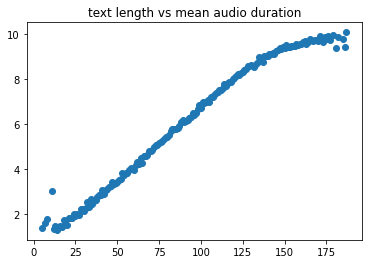

In [28]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

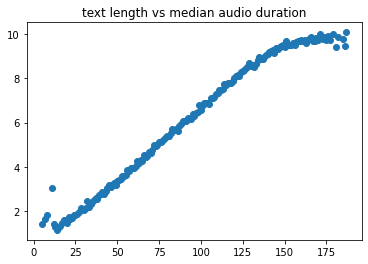

In [29]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

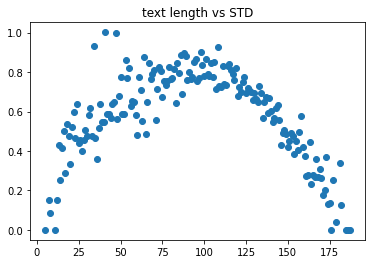

In [30]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

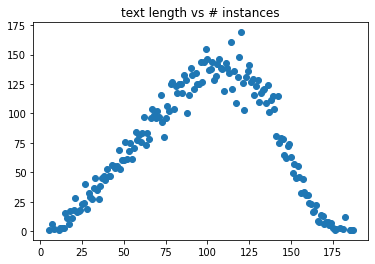

In [31]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

100%|██████████| 13100/13100 [00:00<00:00, 2081974.25it/s]


Text(0.5, 1.0, 'audio length distribution')

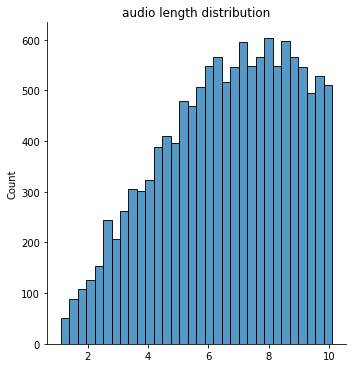

In [38]:
audio_lens = []
for item in tqdm(data):
    audio_len = item[-1]
    audio_lens.append(audio_len)

sns.displot(audio_lens)
plt.title("audio length distribution")

### Check words frequencies

In [39]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [40]:
w_count_df

,0
the,18275
of,8709
and,6390
to,6282
in,4778
...,...
embargo,1
vaccination,1
"hideel,",1
simultaneous,1


In [41]:
# check a certain word
w_count_df.at['minute', 0]

11

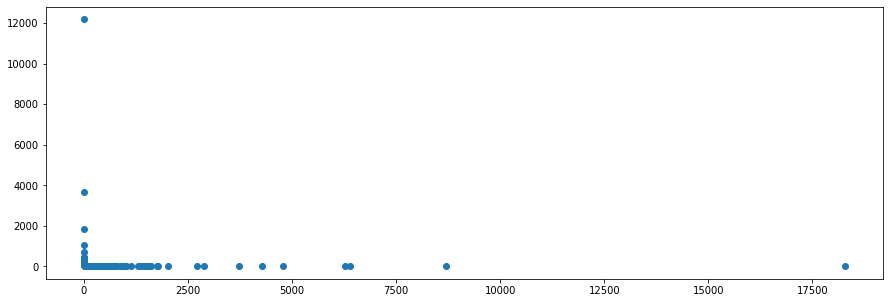

In [64]:
w_count_counter = Counter(w_count.values())
plt.figure(figsize=(15,5))
plt.scatter(list(w_count_counter.keys()), list(w_count_counter.values()))

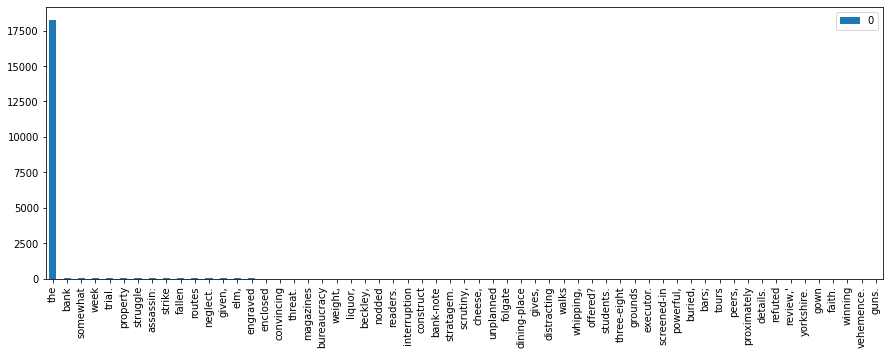

In [49]:
# fequency bar plot - samples
w_count_df.iloc[::400].plot.bar(figsize=(15,5))

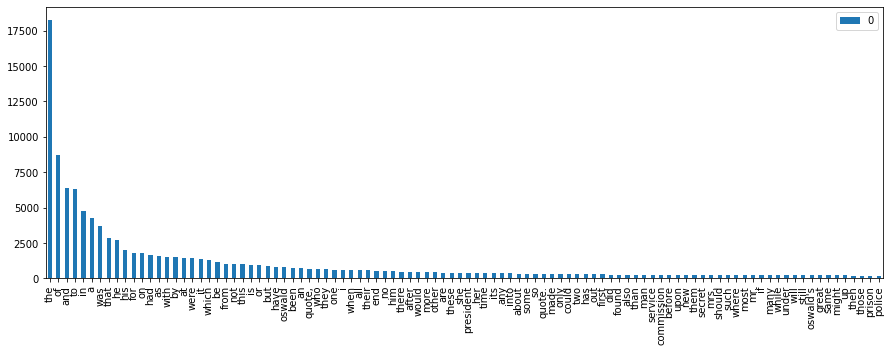

In [50]:
# fequency bar plot - first 100
w_count_df.iloc[:100].plot.bar(figsize=(15,5))

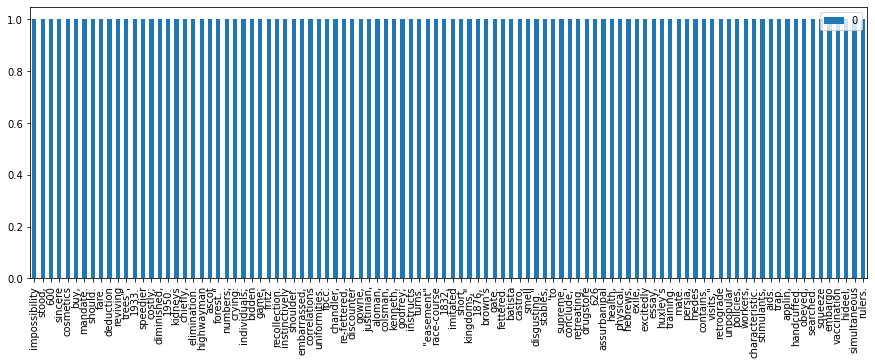

In [51]:
# fequency bar plot - tlastop 100
w_count_df.iloc[-100:].plot.bar(figsize=(15,5))